In [3]:
import os
os.chdir('C:/Users/sh355/Desktop/intern/two sigma/mta data challenge')

In [4]:
import pandas as pd
import urllib
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
%matplotlib inline

# Data analysis:

## Which station has the most number of units?

In [5]:
# read data
rbs = pd.read_csv('Remote-Booth-Station.csv')
stat = rbs.groupby('Station')['Remote'].nunique()
stat[stat == stat.max()]

Station
86 ST       5
CANAL ST    5
Name: Remote, dtype: int64

'86 ST' and 'CANAL ST' have the most number of units. 

## What is the total number of entries & exits across the subway system for August 1, 2013?

In [6]:
# scrape txt file from mta
def read_data(date):
    file = urllib.request.urlopen('http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + str(date) + '.txt')
    l = []
    for line in file:
        mylist = str(line,'utf-8').rstrip().split(',')
        for i in range(3,len(mylist)-3,5):
            l.append(mylist[0:3] + mylist[i:i+5])
    with open(str(date) + '.csv', 'w', newline = '') as rf:
        wr = csv.writer(rf, delimiter = ',')
        wr.writerows(l)

In [7]:
read_data(130803)

In [8]:
d130803 = pd.read_csv('130803.csv', names = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'])

In [9]:
d130803=d130803[d130803['DESC']=="REGULAR"].reset_index(drop=True)

In [10]:
# function to calculate daily entries and exits
def flow(ddate):
    ddate['ENTRIES_DAILY'] = ddate.ENTRIES.shift(-1) - ddate.ENTRIES
    ddate['EXITS_DAILY'] = ddate.EXITS.shift(-1) - ddate.EXITS
    ddate.loc[(ddate.SCP != ddate.SCP.shift(-1)) | (ddate.UNIT != ddate.UNIT.shift(-1)) | 
              (ddate['C/A'] != ddate['C/A'].shift(-1)), 
              ('ENTRIES_DAILY', 'EXITS_DAILY')] = 0
    ddate.loc[ddate.ENTRIES_DAILY < 0, 'ENTRIES_DAILY'] = ddate.ENTRIES.shift(-1)
    ddate.loc[ddate.EXITS_DAILY < 0, 'EXITS_DAILY'] = ddate.EXITS.shift(-1)  

In [11]:
flow(d130803)

In [12]:
d130803[d130803.DATE == '08-01-13']['ENTRIES_DAILY'].sum()

5671990.0

In [13]:
d130803[d130803.DATE == '08-01-13']['EXITS_DAILY'].sum()

4555095.0

## Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [14]:
#define busyness column
d130803['BUSYNESS'] = d130803['ENTRIES_DAILY'] + d130803['EXITS_DAILY']
#add station column to d130803
ucs = rbs[['Remote', 'Booth', 'Station']]
ucs.columns = ['UNIT', 'C/A', 'STATION']
d130803_m = pd.merge(d130803, ucs, how = 'left', on = ['C/A', 'UNIT'])

In [13]:
#analyze busyness on Aug 1st regarding station
day130801 = d130803_m.loc[d130803_m.DATE == '08-01-13']
stat_busy_130801 = day130801.groupby('STATION')['BUSYNESS'].sum()
stat_busy_130801[stat_busy_130801 == stat_busy_130801.max()]

STATION
34 ST-PENN STA    331043.0
Name: BUSYNESS, dtype: float64

In [14]:
#analyze busyness on Aug 1st regarding turnstile
turnstile_busy_130801 = day130801.groupby(['STATION','SCP'])['BUSYNESS'].sum()
turnstile_busy_130801[turnstile_busy_130801 == turnstile_busy_130801.max()]

STATION         SCP     
EXCHANGE PLACE  00-01-00    210773.0
Name: BUSYNESS, dtype: float64

34 ST-PENN STA is the busiest station and 00-01-00 turnstile on station EXCHANGE PLACE is the busiest turnstile on August 1, 2013.

## What stations have seen the most usage growth/decline in 2013?

In [15]:
#function for all the dates in a year
def alldate(year):
    d = date(year, 1, 5)
    l = [d.strftime("%y%m%d")]
    while d.year == year:
        d += timedelta(days = 7)
        l.append(d.strftime("%y%m%d"))    
    return(l)

In [39]:
#read in all the relevant files in 2013 on daily basis
for date in alldate(2013):
    read_data(date)

In [16]:
#concatenate 2013 files into one big dataframe
df13 = pd.concat((pd.read_csv(enddate + '.csv', names = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']) 
                  for enddate in alldate(2013))).sort_values(by=['C/A','UNIT', 'SCP', 'DATE', 'TIME'])

In [17]:
df13 = df13[(df13.DATE != '12-29-12') & (df13.DATE != '12-30-12') & (df13.DATE != '12-31-12') & 
            (df13.DATE != '01-01-14') & (df13.DATE != '01-02-14') & (df13.DATE != '01-03-14')].reset_index(drop=True)

In [18]:
#remove abnormal values
df13_regular=df13[(df13['DESC']=="REGULAR") & (df13['ENTRIES']>=0)&(df13['EXITS']>=0)].reset_index(drop=True)

In [19]:
flow(df13_regular)

In [20]:
#remove abnormal values
df13_regular.loc[(df13_regular.ENTRIES_DAILY > 15000) | (df13_regular.EXITS_DAILY > 15000), ('ENTRIES_DAILY', 'EXITS_DAILY')] = 0

In [21]:
df13_regular['BUSYNESS'] = df13_regular.ENTRIES_DAILY + df13_regular.EXITS_DAILY
df13_m = pd.merge(df13_regular, ucs, how = 'left', on = ['C/A', 'UNIT'])
stat_date_busy = df13_m.groupby(['STATION', 'DATE'])['BUSYNESS'].sum()
# assume station which has largest range in 'BUSYNESS' as most usage growth/decline
stat_busydif = stat_date_busy.max(level=0) - stat_date_busy.min(level=0)
stat_busydif.idxmax()

'PATH WTC'

PATH WTC has seen the most usage growth/decline in 2013.

## What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [22]:
date_busy = df13_m.groupby('DATE')['BUSYNESS'].sum()
date_busy.idxmin()

'12-25-13'

In [23]:
df13_m['DAY'] = pd.to_datetime(df13_m.DATE, format = '%m-%d-%y').map(lambda x: x.strftime('%A'))
df13_m.groupby('DAY')['BUSYNESS'].sum().sort_values()

DAY
Sunday       252342423.0
Saturday     322108853.0
Monday       500781640.0
Friday       531442547.0
Thursday     533068889.0
Tuesday      537643955.0
Wednesday    539754501.0
Name: BUSYNESS, dtype: float64

December 25, 2013 is the least busy. 
Apparently, busyness of weekend is significantly less than the weekdays. Thus, Saturday and Sunday are not operating at full capacity or closed entirely.

# Visualization

## Plot the daily row counts for data files in Q3 2013.

In [24]:
#concatenate Q3 2013 files into one big dataframe
df13_Q3 = pd.concat((pd.read_csv(enddate + '.csv', header = None,names = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']) 
                  for enddate in alldate(2013)[26:40])).sort_values(by=['C/A','UNIT', 'SCP', 'DATE', 'TIME'])

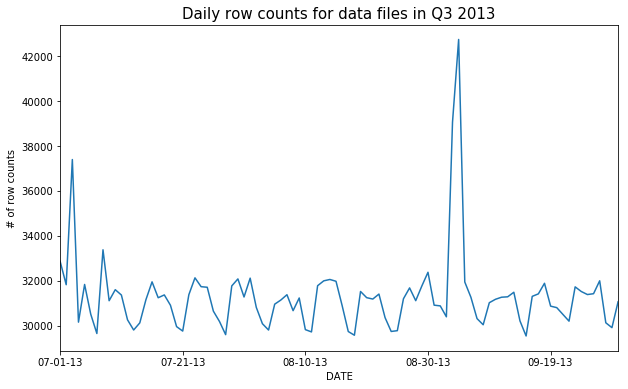

In [25]:
DATE_13Q3 = df13_Q3.groupby(['DATE'])['ENTRIES'].count()
DATE_13Q3[2:(len(DATE_13Q3)-4)].plot(figsize=(10,6))
plt.title('Daily row counts for data files in Q3 2013', fontsize=15)
plt.ylabel('# of row counts')

## Plot the daily total number of entries & exits across the system for Q3 2013.

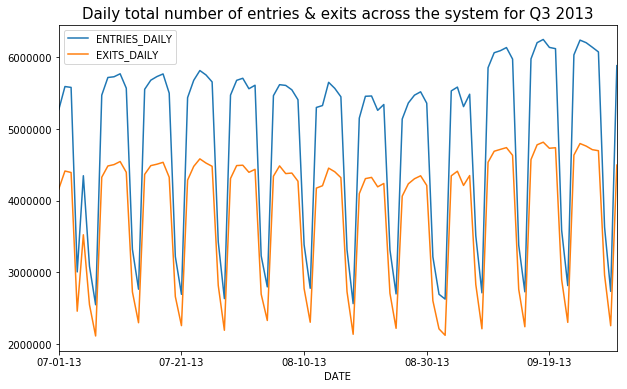

In [26]:
df13q3 = df13_m[(df13_m.DATE >= '07-01-13') & (df13_m.DATE <= '09-30-13')].reset_index(drop = True)
dfp2 = df13q3.groupby('DATE')[('ENTRIES_DAILY', 'EXITS_DAILY')].sum().plot(figsize=(10,6))
plt.title('Daily total number of entries & exits across the system for Q3 2013', fontsize=15)

## Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [27]:
df13q3_penn = df13_m[(df13_m.STATION == '34 ST-PENN STA') & (df13_m.DATE >= '07-01-13') 
                     & (df13_m.DATE <= '09-30-13')].reset_index(drop = True)
df13q3_penn['MON'] = pd.to_datetime(df13q3_penn.DATE, format = '%m-%d-%y').map(lambda x: x.month)
means = df13q3_penn.groupby(['MON', 'DATE'])[('ENTRIES_DAILY', 'EXITS_DAILY')].sum().mean(
    level = 0).rename({7: 'Jul', 8: 'Aug', 9: 'Sep'})
errors = df13q3_penn.groupby(['MON', 'DATE'])[('ENTRIES_DAILY', 'EXITS_DAILY')].sum().std(
    level = 0).rename({7: 'Jul', 8: 'Aug', 9: 'Sep'})

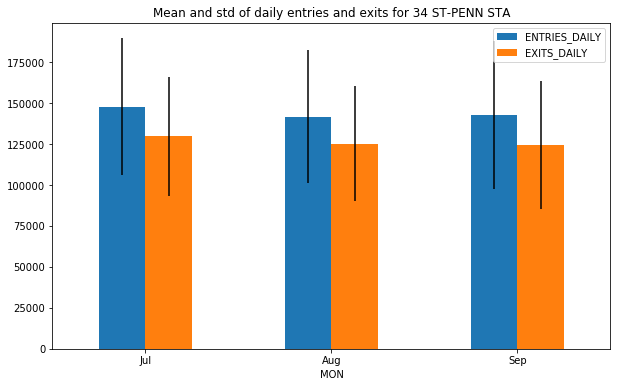

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
means.plot.bar(yerr=errors, ax=ax, rot = 0)
plt.title('Mean and std of daily entries and exits for 34 ST-PENN STA')
plt.show()

## Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

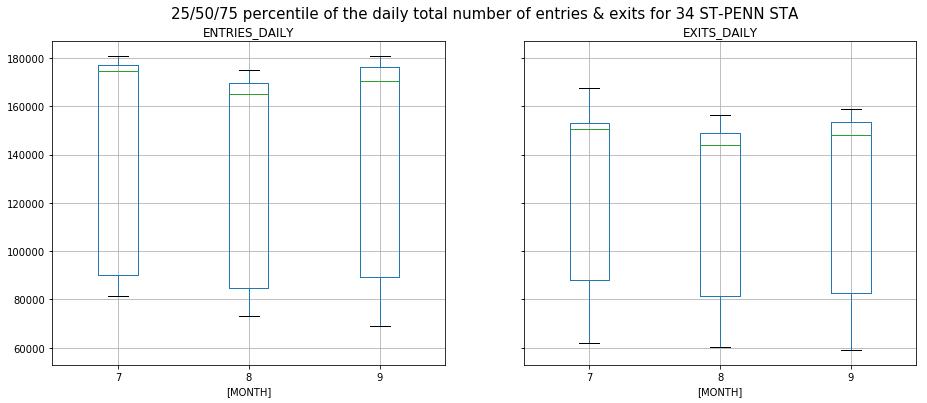

In [29]:
p4 = df13q3_penn.groupby(['MON', 'DATE'])[('ENTRIES_DAILY', 'EXITS_DAILY')].sum()
p4['MONTH'] = list(p4.index.get_level_values('MON'))
p4.boxplot(by='MONTH', figsize = (15, 6))
plt.suptitle("25/50/75 percentile of the daily total number of entries & exits for 34 ST-PENN STA", size = 15)
plt.show()

## Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

### --Daily closed stations number in Q3 2013

In [30]:
df13q3_m = pd.merge(df13q3, ucs, how = 'left', on = ['C/A', 'UNIT','STATION'])
close = df13q3_m.groupby(['STATION', 'DATE'])['BUSYNESS'].sum().reset_index(name='volume')

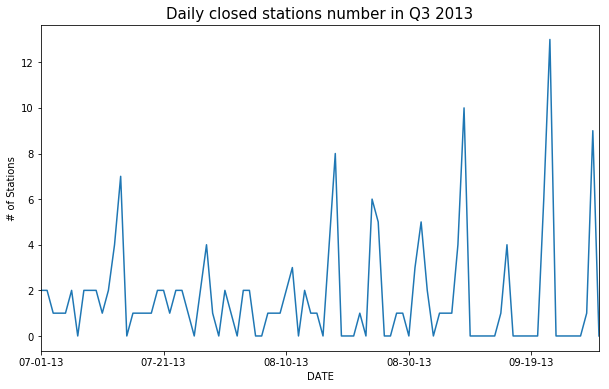

In [31]:
# busyness is less than 10, then assume it a closed station
close['CLOSE'] = [0 if x >= 10 else 1 for x in close['volume']]
close.groupby('DATE')['CLOSE'].sum().plot(figsize=(10,6))
plt.title('Daily closed stations number in Q3 2013', fontsize=15)
plt.ylabel('# of Stations')

### --Daily not operating at full capacity stations number in Q3 2013

In [32]:
df13_q3 = df13_Q3[(df13_Q3.DATE >= '07-01-13') & (df13_Q3.DATE <= '09-30-13')].reset_index(drop = True)
df13_q3 = pd.merge(df13_q3, ucs, how = 'left', on = ['C/A', 'UNIT'])
l=[]
for i in range(len(df13_q3['DESC'])):
    # Because 'REGULAR' in 'DESC' column represents operating at full capacity, other values in that column are something about maintenance
    l.append('regular') if df13_q3['DESC'][i]=='REGULAR' else l.append('nonregular')
df13_q3['Regular']=l
dfclose = df13_q3.groupby(['DATE','Regular'])['STATION'].nunique().reset_index(name='count')

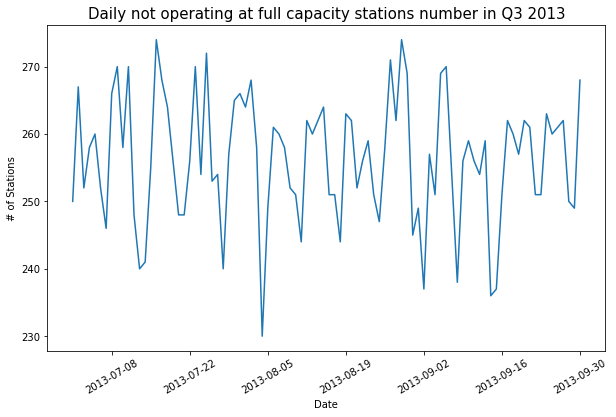

In [33]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
dfclose_non=dfclose[dfclose['Regular']=='nonregular']
ax.plot(pd.to_datetime(dfclose_non['DATE'], format = '%m-%d-%y'), dfclose_non['count'])
ax.set_xlabel('Date')
ax.set_ylabel('# of Stations')
plt.title('Daily not operating at full capacity stations number in Q3 2013', fontsize=15)
plt.xticks(rotation=30)
plt.show()